# Loading Dependencies

In [2]:
#Loading Dependencies

import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import h5py
import os
import sklearn as sk
from sklearn.decomposition import PCA
from timeit import default_timer as timer


from PIL import Image
from IPython.display import display


work_dir = os.getcwd()
print('Current working directory:')
print(work_dir)




print(os.listdir("./data"))

Current working directory:
C:\Users\thorb\OneDrive\Documents\Math TU Delft\USYD ML2\COMP5328 Project 2
['CIFAR.npz', 'FashionMNIST0.5.npz', 'FashionMNIST0.6.npz']


# Loading Data

## 1. Fashion MNIST0.5 

In [3]:
data1 = np.load(work_dir + "./data/FashionMNIST0.5.npz")
X_train1 = data1['Xtr']
Y_train1 = data1['Str']
X_test1 = data1['Xts']
Y_test1 = data1['Yts']

X_train1.shape, Y_train1.shape, X_test1.shape, Y_test1.shape

((18000, 28, 28), (18000,), (3000, 28, 28), (3000,))

In [4]:
set(Y_train1)

{0, 1, 2}

In [5]:
for k in np.random.randint(18000, size=5):
    X_image = X_train1[k]
    display(Image.fromarray(X_image))


In [6]:
T_1 = np.array([[0.5,0.2,0.3],[0.3,0.5,0.2],[0.2,0.3,0.5]])
T_1

array([[0.5, 0.2, 0.3],
       [0.3, 0.5, 0.2],
       [0.2, 0.3, 0.5]])

## 2. MNIST 0.6

In [7]:
data2 = np.load(work_dir + "./data/FashionMNIST0.6.npz")
X_train2 = data2['Xtr']
Y_train2 = data2['Str']
X_test2 = data2['Xts']
Y_test2 = data2['Yts']

X_train2.shape, Y_train2.shape, X_test2.shape, Y_test2.shape

((18000, 28, 28), (18000,), (3000, 28, 28), (3000,))

In [8]:
set(Y_train2)

{0, 1, 2}

In [9]:
for k in np.random.randint(18000, size=5):
    X_image = X_train2[k]
    display(Image.fromarray(X_image))


In [10]:
T_2 = np.array([[0.4,0.3,0.3],[0.3,0.4,0.3],[0.3,0.3,0.4]])
T_2

array([[0.4, 0.3, 0.3],
       [0.3, 0.4, 0.3],
       [0.3, 0.3, 0.4]])

# CIFAR

In [11]:
data3 = np.load(work_dir + "./data/CIFAR.npz")
X_train3 = data3['Xtr']
Y_train3 = data3['Str']
X_test3 = data3['Xts']
Y_test3 = data3['Yts']

X_train3.shape, Y_train3.shape, X_test3.shape, Y_test3.shape

((15000, 32, 32, 3), (15000,), (3000, 32, 32, 3), (3000,))

In [12]:
set(Y_train3)

{0, 1, 2}

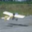

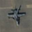

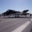

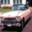

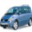

In [13]:
for k in np.random.randint(15000, size=5):
    X_image = X_train3[k]
    display(Image.fromarray(X_image))

## Preprocessing

In [14]:
def encode(Y):
    n,c = Y.size, 3
    Y_encoded = np.zeros((n,c))
    
    for i in range(n):
        Y_encoded[i,Y[i]] = 1
    
    return Y_encoded
    
    

In [15]:
encode(Y_train1).shape

(18000, 3)

# 2. Models

## 2.1 MLR - Multinomial Logistic Regression

In [16]:
#Returns softmax values for n vectors of dimension c
def softmax(array):
    n,c = array.shape
    temp = np.exp(array) #n
    temp2 = temp.sum(axis = 1)
    
    return temp/temp2.reshape(n,1)  #Division row wise

#"mu matrix"
def mu(X,W):
    XW = X@W
    
    return softmax(XW)

In [17]:
# Returns the gradient of the cross error entropy function in W (as per Murphy)
# X nxp
# W pxC
# Y (encoded) nxC
def ceef_grad(X,W,Y):
    Y = encode(Y)
    mu_matrix = mu(X,W) #nxc
    n,p = X.shape
    p,c = W.shape

    grad = np.zeros((p,c))
    for i in range(n):
        grad += np.transpose(np.kron((mu_matrix[i,:] - Y[i,:]),X[i,:]).reshape(c,p))
    
    return grad/n    

In [91]:
def MLR_grad_descent(X,W,Y,eta = 0.01, batch_size = 100, max_iter = 1000, tol = 1e-8):
    N,p = X.shape
    W_old = W.copy()
    counter_iter = 0
    
    while counter_iter < max_iter:
        counter_iter +=1
        #Save copy of W_old
        W_old = W.copy()
        
        #get random batch of size = batch_size
        batch_indices = np.random.randint(N, size = batch_size)
        
        #compute current gradient
        grad = ceef_grad(X[batch_indices],W,Y[batch_indices])
        
        #update W
        W -= eta * grad
        
        if counter_iter % 100 == 0:
            print(counter_iter)
            print(np.linalg.norm(W_old-W)/W.size)
        
        if np.linalg.norm(W_old-W)/W.size < tol:
            break
            
    
    return W

## 2.2 Robust Multinomial Logistic Regression - rMLR

In [19]:
#returns (S_n^k)n,k 
# n in range(N)
# k in range(K)
# where S_n^k = P(y^hat =k | x_n,w)
# gamma = T transition matrix
def Softmax_adjusted(X, W, gamma):
    #get softmax function of X*W
    sftmx = softmax(X@W)
    S =  sftmx.dot(gamma.T)
    return S
    


In [20]:
# X nxp
# W pxK
# Y nxK
# Gamma KxK

def rMLR_grad(X,W,Y,gamma):
    N,p = X.shape
    p,K = W.shape
    Grad = np.zeros((p,K))
    
    S = Softmax_adjusted(X,W,gamma) #adjusted softmax matrix, nxK
    Exp = np.exp(X@W) #exp(XW) matrix nxK
    
    for c in range(K):
        grad_c = np.zeros(p)
        for n in range(N):
            sum = 0
            for k in range(K):
                sum+= Y[n,k]/S[n,k] * Exp[n,:].dot(gamma[c,k]-gamma[:,k])
            grad_c += sum * Exp[n,c]/(np.sum(Exp[n,:]))**2 * X[n,:]
        Grad[:,c] = grad_c
    
    return Grad/N
    
    
    

In [21]:
def rMLR_grad_descent(X,W,Y,gamma,eta = 0.01, batch_size = 100, max_iter = 250, tol = 1e-8):
    N,p = X.shape
    Y = encode(Y)
    W_old = W.copy()
    counter_iter = 0
    
    while counter_iter < max_iter:
        counter_iter +=1
        #Save copy of W_old
        W_old = W.copy()
        
        #get random batch of size = batch_size
        batch_indices = np.random.randint(N, size = batch_size)
        
        #compute current gradient
        grad = -rMLR_grad(X,W,Y,gamma)
        
        #update W
        W -= eta * grad
        
        if counter_iter % 50 == 0:
            print(counter_iter)
            print(np.linalg.norm(W_old-W)/W.size)

        if np.linalg.norm(W_old-W)/W.size < tol:
            break
            
    
    return W

### 2.2b rMLR with unkown flip rates

In [22]:
def MU_gamma(gamma, W, X, Y):
    n,p = X.shape
    n,c = Y.shape
    
    S = Softmax_adjusted(X,W,gamma)
    sftmx = softmax(X@W)
    gamma_update = np.zeros(gamma.shape)
    
    for j in range(c):
        for k in range(c):
            gamma_update[j,k] = np.transpose(gamma)[j,k] * np.dot(np.transpose(Y/S)[k,:],sftmx[:,j]) 
            
    
    temp2 = gamma_update.sum(axis = 1)

    gamma_update = gamma_update/temp2.reshape(c,1)    
    
    return np.transpose(gamma_update)

In [118]:
def rMLR_flipunknown_grad_descent(X,W,Y,gamma,eta = 0.01, batch_size = 100, max_iter = 100, tol = 1e-8):
    N,p = X.shape
    Y = encode(Y)
    W_old = W.copy()
    counter_iter = 0
    
    while counter_iter < max_iter:
        counter_iter +=1
        #Save copy of W_old
        W_old = W.copy()
        
        #get random batch of size = batch_size
        batch_indices = np.random.randint(N, size = batch_size)
        
        #compute current gradient
        grad = -rMLR_grad(X,W,Y,gamma)
        
        #update W
        W -= eta * grad
        
        #Update gamma: pointwise mult
        gamma = MU_gamma(gamma, W,X,Y)        
        
        if counter_iter % 50 == 0:
            print(counter_iter)
            print(np.linalg.norm(W_old-W)/W.size)

        if np.linalg.norm(W_old-W)/W.size < tol:
            break
            
    
    return W,gamma

# 3. Runs
## 3.1 Functions to Call

In [37]:
#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=# LOAD RESULTS DATAFRAME #=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#
validation_results_df = 'insert'

In [38]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [39]:
#X nxp
#W pxc
def get_predictions(X,W):
    n,p = X.shape
    predictions = np.zeros(n)
    
    #softmax(XW)
    mu_matrix = mu(X,W)
    for i in range(n):
        predictions[i] = np.argmax(mu_matrix[i,:])
    
    return predictions  

In [40]:
# Assumes: W trained on noisy data
# T transformation matrix of flipping rates
def get_transformed_predictions(X,W,T):
    n,p = X.shape
    predictions = np.zeros(n)
    
    #Softmax(X,W) nxC, probabilites based on noisy training
    mu_matrix = mu(X,W)
    
    #Apply Transformation
    clean_mu = mu_matrix.dot(T)
    
    for i in range(n):
        predictions[i] = np.argmax(clean_mu[i,:])
    
    return predictions

In [41]:
def get_accuracy(predictions,Y):
    N = predictions.size
    k = len(np.where(predictions==Y)[0])
    
    return k/N

In [116]:
def cv_run(X_train, W_init, Y_train, X_test, Y_test, method, num_folds, T, **kwargs):
    n,p = X_train.shape
    p,c = W_init.shape
    accuracy_results = np.zeros(num_folds)
        
    #Split X_train, Y_train into 10 folds, containing 90% of set each
    fold_size = n /num_folds
    for k in range(num_folds):
        print("Fold number: " + str(k))
        training_index = np.concatenate([np.arange(0,k*fold_size,1),np.arange((k+1)*fold_size,n,1)]).astype(int)
        
        X_train_fold = X_train[training_index]
        Y_train_fold = Y_train[training_index]
        #Standardize X_train and X_test
        mean = np.mean(X_train_fold,axis = 0)
        std = np.std(X_train_fold,axis = 0)
        
        X_train_fold = (X_train_fold - mean)/std
        X_test_fold = (X_test - mean)/std

        
        #Running the method:
        
        if method == 'MLR':
            #fit W
            W = MLR_grad_descent(X_train_fold, W_init, Y_train_fold)
            
            #predict on test set
            predictions = get_predictions(X_test_fold,W)
            
            #get accuracy
            accuracy_results[k] = get_accuracy(predictions,Y_test)
            
        elif method == 'MLR_flip':
            W = MLR_grad_descent(X_train_fold, W_init, Y_train_fold)
            
            #predict on test set
            predictions = get_transformed_predictions(X_test_fold,W,T)
            
            #get accuracy
            accuracy_results[k] = get_accuracy(predictions,Y_test)
            
        elif method == 'rMLR_flip':
            #fit W
            W = rMLR_grad_descent(X_train_fold, W_init, Y_train_fold, T)
            
            #predict on test test
            predictions = get_predictions(X_test_fold,W)
            
            #get accuracy
            accuracy_results[k] = get_accuracy(predictions,Y_test)

        elif method == 'rMLR':
            #fit W and gamma:
            gamma_init = T_1
            W,gamma = rMLR_flipunknown_grad_descent(X_train_fold,W_init,Y_train_fold,gamma_init)
            print(gamma)
            
            #predict on test test
            predictions = get_predictions(X_test_fold,W)
            
            #get accuracy
            accuracy_results[k] = get_accuracy(predictions,Y_test)
            
    
    return np.array([accuracy_results, np.mean(accuracy_results),np.std(accuracy_results)])
    
    
    
    

## 3.2 .. on MNIST0.5

In [237]:
X_train1 = X_train1.reshape(18000,28*28)
X_test1 = X_test1.reshape(3000,28*28)
W_init = 0.1 * np.random.rand(28*28,3)

results_mnist05_MLR_flip = cv_run(X_train1, W_init, Y_train1, X_test1, Y_test1, 'MLR_flip', num_folds = 10, T = T_1)

results_mnist05_MLR = cv_run(X_train1, W_init, Y_train1, X_test1, Y_test1, 'MLR', num_folds = 10, T = T_1)

results_mnist05_rMLR_flip = cv_run(X_train1, W_init, Y_train1, X_test1, Y_test1, 'rMLR_flip', num_folds = 10, T = T_1)



results_mnist05_MLR_flip, results_mnist05_MLR,results_mnist05_rMLR_flip

Fold number: 0
Fold number: 1
Fold number: 2
Fold number: 3
Fold number: 4
Fold number: 5
Fold number: 6
Fold number: 7
Fold number: 8
Fold number: 9
Fold number: 0
Fold number: 1
Fold number: 2
Fold number: 3
Fold number: 4
Fold number: 5
Fold number: 6
Fold number: 7
Fold number: 8
Fold number: 9
Fold number: 0
50
4.2860409950768996e-07
100
2.858901822951177e-07
150
2.160727451766593e-07
200
1.7548367509340677e-07
250
1.489419210601886e-07
Fold number: 1
50
1.2267660866437515e-07
100
1.1083838565704503e-07
150
1.0169755951448085e-07
Fold number: 2
50
1.0197229259079685e-07
Fold number: 3
Fold number: 4
Fold number: 5
Fold number: 6
Fold number: 7
Fold number: 8
Fold number: 9


((array([0.83633333, 0.85633333, 0.84933333, 0.84733333, 0.82166667,
         0.85533333, 0.82966667, 0.80933333, 0.811     , 0.825     ]),
  0.8341333333333333,
  0.01661739383230046),
 (array([0.77966667, 0.74433333, 0.74      , 0.763     , 0.75966667,
         0.762     , 0.774     , 0.74366667, 0.80066667, 0.77966667]),
  0.7646666666666666,
  0.018250722968937105),
 (array([0.88533333, 0.89033333, 0.89033333, 0.89233333, 0.892     ,
         0.89366667, 0.893     , 0.89266667, 0.89366667, 0.89333333]),
  0.8916666666666666,
  0.0024037008503093463))

In [254]:
import pandas as pd
results_mnist05_MLR_df = pd.DataFrame(np.array([results_mnist05_MLR[0],results_mnist05_MLR[1],results_mnist05_MLR[2]]))
results_mnist05_MLR_df.to_csv('results_mnist05_MLR.csv')

results_mnist05_MLR_flip_df = pd.DataFrame(np.array([results_mnist05_MLR_flip[0],results_mnist05_MLR_flip[1],results_mnist05_MLR_flip[2]]))
results_mnist05_MLR_flip_df.to_csv('results_mnist05_MLR_flip.csv')

results_mnist05_rMLR_flip_df = pd.DataFrame(np.array([results_mnist05_rMLR_flip[0],results_mnist05_rMLR_flip[1],results_mnist05_rMLR_flip[2]]))
results_mnist05_rMLR_flip_df.to_csv('results_mnist05_rMLR_flip.csv')


## 3.3 .. on MNIST0.6









In [258]:
X_train2 = X_train2.reshape(18000,28*28)
X_test2 = X_test2.reshape(3000,28*28)
W_init = 0.1 * np.random.rand(28*28,3)

results_mnist06_MLR_flip = cv_run(X_train2, W_init, Y_train2, X_test2, Y_test2, 'MLR_flip', num_folds = 10, T = T_2)

results_mnist06_MLR = cv_run(X_train2, W_init, Y_train2, X_test2, Y_test2, 'MLR', num_folds = 10, T = T_2)

results_mnist06_rMLR_flip = cv_run(X_train2, W_init, Y_train2, X_test2, Y_test2, 'rMLR_flip', num_folds = 10, T = T_2)




results_mnist06_MLR_flip, results_mnist06_MLR,results_mnist06_rMLR_flip

Fold number: 0
Fold number: 1
Fold number: 2
Fold number: 3
Fold number: 4
Fold number: 5
Fold number: 6
Fold number: 7
Fold number: 8
Fold number: 9
Fold number: 0
Fold number: 1
Fold number: 2
Fold number: 3
Fold number: 4
Fold number: 5
Fold number: 6
Fold number: 7
Fold number: 8
Fold number: 9
Fold number: 0
50
1.7948297940125618e-07
100
1.4594625589734615e-07
150
1.2396356264048072e-07
200
1.0817051755651742e-07
Fold number: 1
Fold number: 2
Fold number: 3
Fold number: 4
Fold number: 5
Fold number: 6
Fold number: 7
Fold number: 8
Fold number: 9


(array([array([0.64866667, 0.596     , 0.682     , 0.61566667, 0.58333333,
        0.62866667, 0.55933333, 0.641     , 0.58133333, 0.50466667]),
        0.6040666666666668, 0.048020551156076216], dtype=object),
 array([array([0.58066667, 0.62133333, 0.58166667, 0.62833333, 0.623     ,
        0.49366667, 0.57333333, 0.64633333, 0.65033333, 0.58566667]),
        0.5984333333333333, 0.04401793826258664], dtype=object),
 array([array([0.80733333, 0.81333333, 0.81366667, 0.813     , 0.81266667,
        0.81433333, 0.81266667, 0.814     , 0.814     , 0.81466667]),
        0.8129666666666665, 0.001985782801147521], dtype=object))

In [263]:
results_mnist06_MLR_df = pd.DataFrame(results_mnist06_MLR)
results_mnist06_MLR_df.to_csv('results_mnist06_MLR.csv')


results_mnist06_MLR_flip_df = pd.DataFrame(results_mnist06_MLR_flip)
results_mnist06_MLR_flip_df.to_csv('results_mnist06_MLR_flip.csv')


results_mnist06_rMLR_flip_df = pd.DataFrame(results_mnist06_rMLR_flip)
results_mnist06_rMLR_flip_df.to_csv('results_mnist06_rMRL_flip.csv')

## 3.3 .. on CIFAR

In [103]:
#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=# Using T_3, estimated by the NN, as constant #=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#

T_3 = np.array([[0.36601161, 0.32905289 ,0.3049355 ],
                 [0.27715348, 0.41431034, 0.30853618],
                 [0.28299314, 0.32606457, 0.39094229]])

In [108]:
X_train3 = X_train3.reshape(15000,32*32*3)
X_test3 = X_test3.reshape(3000,32*32*3)
W_init = 0.1 * np.random.rand(32*32*3,3)

results_cifar_MLR_flip = cv_run(X_train3, W_init, Y_train3, X_test3, Y_test3, 'MLR_flip', num_folds = 10, T = T_3)

results_cifar_MLR = cv_run(X_train3, W_init, Y_train3, X_test3, Y_test3, 'MLR', num_folds = 10, T = T_3)

results_cifar_rMLR_flip = cv_run(X_train3, W_init, Y_train3, X_test3, Y_test3, 'rMLR_flip', num_folds = 10, T = T_3)




results_cifar_MLR_flip, results_cifar_MLR,results_cifar_rMLR_flip

Fold number: 0
100
9.24401646525511e-06
200
1.5023985537573791e-05
300
1.3365298904218161e-05
400
1.265313614214839e-05
500
1.1357653310076573e-05
600
1.6911797310603165e-05
700
9.42119979904477e-06
800
1.4586551690385911e-05
900
6.245023962065279e-06
1000
1.1989608578933146e-05
Fold number: 1
100
1.144298449916024e-05
200
1.186260249387225e-05
300
1.1321296622094346e-05
400
9.578290556998702e-06
500
1.2822267564464823e-05
600
1.3597149613728885e-05
700
9.544314804590579e-06
800
1.1019717833565867e-05
900
1.3571280739956763e-05
1000
1.6760921564377065e-05
Fold number: 2
100
1.2593264097072134e-05
200
1.3207422988076837e-05
300
1.2418480010482261e-05
400
1.2374746030800028e-05
500
1.368678609901953e-05
600
9.524370861457916e-06
700
4.76643808045517e-06
800
1.4281993437358204e-05
900
1.1363413472573745e-05
1000
9.907468577449987e-06
Fold number: 3
100
1.2798348534825543e-05
200
1.517762718498034e-05
300
1.543355728530397e-05
400
6.0637338126562315e-06
500
1.1447289678979592e-05
600
1.292

(array([array([0.35566667, 0.359     , 0.42933333, 0.41166667, 0.29933333,
        0.45566667, 0.38666667, 0.37633333, 0.33066667, 0.37066667]),
        0.37750000000000006, 0.043838909657973935], dtype=object),
 array([array([0.459     , 0.33933333, 0.35233333, 0.433     , 0.314     ,
        0.29      , 0.24133333, 0.36433333, 0.428     , 0.311     ]),
        0.35323333333333334, 0.0658024062376648], dtype=object),
 array([array([0.46066667, 0.47066667, 0.48033333, 0.482     , 0.47333333,
        0.48366667, 0.48733333, 0.48066667, 0.47966667, 0.473     ]),
        0.47713333333333335, 0.007375936851983244], dtype=object))

In [109]:
results_cifar_MLR_df = pd.DataFrame(results_cifar_MLR)
results_cifar_MLR_df.to_csv('results_cifar_MLR.csv')


results_cifar_MLR_flip_df = pd.DataFrame(results_cifar_MLR_flip)
results_cifar_MLR_flip_df.to_csv('results_cifar_MLR_flip.csv')


results_cifar_rMLR_flip_df = pd.DataFrame(results_cifar_rMLR_flip)
results_cifar_rMLR_flip_df.to_csv('results_cifar_rMRL_flip.csv')

#### CIFAR run without known flip rates:

In [119]:
results_cifar_rMLR = cv_run(X_train3, W_init, Y_train3, X_test3, Y_test3, 'rMLR', num_folds = 10, T = T_3)


Fold number: 0
50
2.28014764002689e-08
100
3.5377309630500974e-08
[[0.33001162 0.33431863 0.33180603]
 [0.32927793 0.31566045 0.3593092 ]
 [0.34071046 0.35002092 0.30888477]]
Fold number: 1
[[0.3292742  0.33447324 0.33392067]
 [0.33408093 0.32649823 0.34011579]
 [0.33664487 0.33902853 0.32596354]]
Fold number: 2
[[0.33157537 0.33696443 0.33276268]
 [0.3290871  0.33038847 0.33742463]
 [0.33933753 0.33264711 0.32981269]]
Fold number: 3
[[0.33275361 0.33784378 0.32846411]
 [0.32829739 0.33103677 0.33996995]
 [0.338949   0.33111944 0.33156594]]
Fold number: 4
50
1.7319326554924294e-08
100
1.9290896019763e-08
[[0.33138166 0.35206704 0.31563529]
 [0.33724669 0.32480841 0.33790576]
 [0.33137165 0.32312454 0.34645895]]
Fold number: 5
50
4.0736438944202524e-08
100
3.9844538157361624e-08
[[0.34013542 0.36880064 0.30149492]
 [0.34570548 0.32804277 0.32174797]
 [0.3141591  0.30315659 0.37675711]]
Fold number: 6
50
3.1143026703368594e-08
100
2.7832077511114678e-08
[[0.33775575 0.3672102  0.304657  

In [120]:
results_cifar_rMLR 

array([array([0.29933333, 0.29933333, 0.303     , 0.29866667, 0.33066667,
       0.38233333, 0.40566667, 0.423     , 0.43433333, 0.433     ]),
       0.36093333333333333, 0.05712360866285206], dtype=object)

In [124]:
M1 = np.array([[0.33001162, 0.33431863, 0.33180603],
 [0.32927793, 0.31566045, 0.3593092 ],
 [0.34071046, 0.35002092, 0.30888477]])

M2 = np.array([[0.3292742,0.33447324 ,0.33392067],
 [0.33408093, 0.32649823, 0.34011579],
 [0.33664487, 0.33902853, 0.32596354]])
M3 = np.array([[0.33157537, 0.33696443, 0.33276268],
 [0.3290871 , 0.33038847, 0.33742463],
 [0.33933753, 0.33264711 ,0.32981269]])
M4 = np.array([[0.33275361, 0.33784378, 0.32846411],
 [0.32829739, 0.33103677, 0.33996995],
 [0.338949,   0.33111944, 0.33156594]])
M5 = np.array([[0.33138166 ,0.35206704, 0.31563529],
 [0.33724669, 0.32480841, 0.33790576],
 [0.33137165, 0.32312454, 0.34645895]])
M6 = np.array([[0.34013542, 0.36880064, 0.30149492],
 [0.34570548, 0.32804277, 0.32174797],
 [0.3141591,  0.30315659 ,0.37675711]])
M7 = np.array([[0.33775575, 0.3672102,  0.304657  ],
 [0.35128046, 0.33244404, 0.3116884 ],
 [0.3109638 , 0.30034577, 0.38365459]])
M8 = np.array([[0.34009013, 0.3682421,  0.29825932],
 [0.34750308, 0.33807529, 0.31269371],
 [0.31240679, 0.29368261, 0.38904697]])
M9 = np.array([[0.3347032 , 0.36600135 ,0.30074538],
 [0.35338378, 0.34491549, 0.30247783],
 [0.31191302, 0.28908316, 0.39677679]])
M10 = np.array([[0.3378172,  0.36641122, 0.30016853],
 [0.35761549, 0.33979554, 0.30268097],
 [0.30456731, 0.29379325, 0.3971505 ]])

In [129]:
# Gathering the average transformation matrix:
C = np.zeros((10, M1.shape[0], M1.shape[1]))
C[0,:,:] = M1
C[1,:,:] = M2
C[2,:,:] = M3
C[3,:,:] = M4
C[4,:,:] = M5
C[5,:,:] = M6
C[6,:,:] = M7
C[7,:,:] = M8
C[8,:,:] = M9
C[9,:,:] = M10

np.mean(C, axis=0), np.std(C,axis = 0)

(array([[0.33454982, 0.35323326, 0.31479139],
        [0.34134783, 0.33116655, 0.32660142],
        [0.32410235, 0.31560019, 0.35860718]]),
 array([[0.00391675, 0.01487353, 0.01459445],
        [0.01049278, 0.00791135, 0.01808203],
        [0.01370034, 0.0209006 , 0.031736  ]]))

### 3.4 MLR -  Max Accuracy Runs
##### CV 5-fold on test data; to get prediction quality on data without label noise

In [90]:
def max_acc_run(X,W_init, Y, num_folds):
    n,p = X.shape
    p,c = W_init.shape

    accuracy_results = np.zeros(num_folds)
        
    #Split X_train, Y_train into 10 folds, containing 90% of set each
    fold_size = n /num_folds
    
    for k in range(num_folds):
        print("Fold number: " + str(k))
        training_index = np.concatenate([np.arange(0,k*fold_size,1),np.arange((k+1)*fold_size,n,1)]).astype(int)
        test_index = np.arange(k*fold_size,(k+1)*fold_size).astype(int)
        
        
        
        X_train = X[training_index]
        Y_train = Y[training_index]
        
        X_test = X[test_index]
        Y_test = Y[test_index]
        
        #Standardize X_train and X_test
        #mean = np.mean(X_train,axis = 0)
        #std = np.std(X_train,axis = 0)
        
       # X_train = (X_train - mean)/std
        #X_test = (X_test - mean)/std
        
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        

        #fit W
        W = MLR_grad_descent(X_train, W_init, Y_train)
            
        #predict on test set
        predictions = get_predictions(X_test,W)
            
        #get accuracy
        accuracy_results[k] = get_accuracy(predictions,Y_test)
            
    
    
    return np.array([accuracy_results, np.mean(accuracy_results),np.std(accuracy_results)])
    
    
    
    

In [87]:
W_init = 0.1 *np.random.rand(28*28,3)

results_mnist05_max_acc_run =max_acc_run(X_test1.reshape(3000,28*28),W_init, Y_test1, num_folds=5)

Fold number: 0
after stand: 


C:\Users\thorb\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\thorb\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\thorb\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


[[ 0.          0.          0.        ]
 [-0.02254008  0.02210889  0.0004312 ]
 [-0.03516428  0.02173907  0.01342521]
 ...
 [-0.04227545  0.02350188  0.01877357]
 [-0.02837104  0.01194182  0.01642922]
 [-0.01984937  0.02025388 -0.00040451]]
1
2.7820705476653964e-05
2
2.2035675008860806e-05
3
1.8568719392599313e-05
4
1.3204610559242398e-05
5
1.061659091381834e-05
6
1.3467191633449974e-05
7
1.0336094203884745e-05
8
9.863517375761616e-06
9
9.897143972259335e-06
10
8.175039164653205e-06
11
6.188456231963448e-06
12
7.071181946370952e-06
13
6.5616363378840025e-06
14
9.703522431074862e-06
15
6.799386655738743e-06
16
6.994251069203076e-06
17
5.799878503712471e-06
18
5.943091019326752e-06
19
7.4869849903832625e-06
20
5.852148656214688e-06
21
5.746980765670377e-06
22
8.208102644976765e-06
23
5.472283373374272e-06
24
5.880174442579686e-06
25
6.481933585178777e-06
26
6.167549422475071e-06
27
4.867725245316296e-06
28
5.107450379967621e-06
29
7.890936736732621e-06
30
4.6534902755618674e-06
31
4.53572

325
3.2047647225484898e-06
326
3.0876879223441128e-06
327
2.4538844194474717e-06
328
4.091409595896488e-06
329
4.199499893633713e-06
330
2.0893245465257685e-06
331
2.9575204936682033e-06
332
5.197515158917807e-06
333
2.28118245169791e-06
334
3.5147677959747867e-06
335
3.0145016919357287e-06
336
2.1643330357382064e-06
337
2.775202598422947e-06
338
2.09100379183903e-06
339
2.8307147525471668e-06
340
3.7448618174876777e-06
341
2.7117958610052806e-06
342
3.0252015349712767e-06
343
3.176742844995342e-06
344
2.7901145892967924e-06
345
1.889491493504291e-06
346
2.894683352253395e-06
347
3.640100044373852e-06
348
2.485777098733896e-06
349
2.2926341737533304e-06
350
3.302697276943933e-06
351
3.013539073349846e-06
352
3.0786013332634735e-06
353
2.3190401436869143e-06
354
2.605738796683329e-06
355
2.8429724772484815e-06
356
2.667268676691037e-06
357
3.0829903750631885e-06
358
3.333317525859282e-06
359
2.331832709734109e-06
360
3.2588306107084087e-06
361
2.615280890416079e-06
362
3.846015254211452

644
2.141508710534204e-06
645
2.8664061533995628e-06
646
2.6638393561688715e-06
647
4.974155502175783e-06
648
2.486029760495861e-06
649
3.2073330186785516e-06
650
2.645464705627303e-06
651
2.2502455854363322e-06
652
3.77935071590666e-06
653
1.5441791430683041e-06
654
2.6848169298984512e-06
655
2.43696958853819e-06
656
2.7628685724398873e-06
657
2.4520187828112485e-06
658
3.0353613937283245e-06
659
1.7251325235797317e-06
660
2.6537924328273635e-06
661
2.2073307390317733e-06
662
3.132437721204034e-06
663
1.8036424864375494e-06
664
2.9508484516889557e-06
665
2.8542537617219984e-06
666
2.0687758759505622e-06
667
2.251576806934712e-06
668
2.7557934701057387e-06
669
2.8942102949593517e-06
670
1.9448573830111058e-06
671
4.308727485974184e-06
672
2.4137804756946226e-06
673
1.6796040190175559e-06
674
2.989183802111244e-06
675
2.450384230753881e-06
676
2.3281906000710472e-06
677
2.671605814470674e-06
678
2.5038749485637327e-06
679
1.7719616064758896e-06
680
2.467500847984654e-06
681
3.2492401915

961
3.193862884481886e-06
962
2.041801521682216e-06
963
3.139923016408756e-06
964
3.805805175090399e-06
965
2.337764418327544e-06
966
2.521922172720191e-06
967
3.819886788826781e-06
968
4.3718854949915915e-06
969
2.747883999940591e-06
970
2.0900742221600113e-06
971
2.1290089236942982e-06
972
2.72577730047377e-06
973
1.795394617857531e-06
974
2.450181010589833e-06
975
1.985097697419534e-06
976
2.6841071179572854e-06
977
4.268818318552685e-06
978
1.7010527458833485e-06
979
1.2881439437870175e-06
980
1.916427947076605e-06
981
3.7282005656241464e-06
982
3.1353976244815983e-06
983
3.4327354426768494e-06
984
3.2797623326664304e-06
985
2.8634766802440466e-06
986
1.9998757163491505e-06
987
2.1818211537597263e-06
988
2.4842435798726126e-06
989
2.317367540106071e-06
990
2.178893240926122e-06
991
2.874171014477802e-06
992
3.2018600082943448e-06
993
2.8853163003997652e-06
994
2.45384450116976e-06
995
3.1242295741906705e-06
996
2.672134416227341e-06
997
2.0280641661180268e-06
998
3.292276954605973e

C:\Users\thorb\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\thorb\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\thorb\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


after stand: 
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 7.79816807e-05  3.10369707e-05 -1.09018651e-04]
 [-8.94184690e-05  5.17368520e-05  3.76816170e-05]
 ...
 [-2.74437251e-04  1.02737233e-04  1.71700018e-04]
 [ 3.87466409e-05  1.74715787e-05 -5.62182196e-05]
 [ 4.02847993e-05  1.59432580e-05 -5.62280574e-05]]
1
2.858907078752541e-06
2
3.5926273184902084e-06
3
3.2656380880383446e-06
4
2.895044755492432e-06
5
7.638054231456938e-06
6
2.7288319433552502e-06
7
2.2847797553055846e-06
8
3.6811182752934293e-06
9
2.6759221614317745e-06
10
3.9473733402691294e-06
11
3.7717803480238888e-06
12
2.0123771423593227e-06
13
2.7982177322125757e-06
14
5.7678848946417875e-06
15
2.799128913204304e-06
16
3.5156787149206204e-06
17
2.536956060048761e-06
18
1.4508531588196252e-06
19
2.4194011670699685e-06
20
3.415081818614225e-06
21
3.519362709449756e-06
22
3.1292072659325926e-06
23
2.669216287446111e-06
24
1.581137832285233e-06
25
2.4339078641759087e-06
26
3.7532643487987758e-06
27
5.97656281824

306
2.7515679454654613e-06
307
2.1579322200891685e-06
308
1.8195604803678123e-06
309
1.802518363786866e-06
310
5.8736922211388285e-06
311
3.0994252203836732e-06
312
1.7713141900015714e-06
313
2.1501354389260607e-06
314
3.872828773582123e-06
315
2.355579821841265e-06
316
3.210830011680259e-06
317
1.8479656096345162e-06
318
2.668708786138868e-06
319
2.8641157738849713e-06
320
2.1491275975133836e-06
321
1.7399230661340896e-06
322
1.8648303802708208e-06
323
2.307627600844652e-06
324
3.526879997476345e-06
325
2.4151935104920577e-06
326
2.0528466010084204e-06
327
3.2629959181150653e-06
328
2.2848090874860247e-06
329
2.4077612233679245e-06
330
2.4975548641183396e-06
331
1.667284131803089e-06
332
3.105572620731599e-06
333
3.7673913797411673e-06
334
3.0687227051650414e-06
335
1.7372932893234505e-06
336
2.5111775056560162e-06
337
3.0535878110819447e-06
338
2.3084159948781872e-06
339
3.097071008918775e-06
340
3.843990482001344e-06
341
1.8762223845733812e-06
342
3.1686381703130958e-06
343
1.641008

617
2.5261093554501925e-06
618
2.696769406939651e-06
619
1.707697607141329e-06
620
2.009438421487767e-06
621
2.858910549680124e-06
622
2.7351129922042747e-06
623
3.2873664631787287e-06
624
1.770163316149233e-06
625
3.85321788563016e-06
626
1.538758807233819e-06
627
2.1125473962955574e-06
628
1.820971769002212e-06
629
2.08642334538077e-06
630
2.669794117005825e-06
631
1.976881327384999e-06
632
2.436246874483859e-06
633
1.9959643474542485e-06
634
1.9144477317208224e-06
635
1.966449848316262e-06
636
2.1728361047225626e-06
637
2.20150450479862e-06
638
3.067456452154088e-06
639
3.190433407008309e-06
640
2.851725304958631e-06
641
2.7029584859633097e-06
642
2.4289280437568717e-06
643
2.4952791484935735e-06
644
2.0130069624045875e-06
645
2.184441244544248e-06
646
2.44101916848069e-06
647
2.037548801719557e-06
648
2.1099467916115086e-06
649
2.52329235101467e-06
650
2.2691221816483392e-06
651
1.3962947086462886e-06
652
1.6535534280246535e-06
653
1.8694235287220423e-06
654
2.9447093845519916e-06


943
1.9428553530610963e-06
944
2.021628760965062e-06
945
1.8234864722632818e-06
946
9.724978677258964e-07
947
1.7112099872804902e-06
948
1.7305184449006552e-06
949
2.2206209782244185e-06
950
1.6675702888232933e-06
951
3.0525525297681893e-06
952
2.3676846627528927e-06
953
2.1577281475314863e-06
954
2.146154655285859e-06
955
3.1222540379098084e-06
956
2.710714210550335e-06
957
2.2837420264941015e-06
958
2.499750534447589e-06
959
1.4621315159252431e-06
960
2.112238316691966e-06
961
3.176077309911121e-06
962
2.5989075305739184e-06
963
3.297709319321884e-06
964
2.906288051564958e-06
965
1.9865493035662277e-06
966
4.426817769193558e-06
967
2.4296480050897338e-06
968
4.018355954345031e-06
969
3.1153410584104266e-06
970
1.946217829543216e-06
971
2.7661574465076115e-06
972
1.1390399812334337e-06
973
2.3751526418097163e-06
974
1.2433939390674282e-06
975
3.1089143897257298e-06
976
2.4124400023480497e-06
977
3.3288102160748968e-06
978
1.7115336988598955e-06
979
1.6297442869061514e-06
980
2.7041017

C:\Users\thorb\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\thorb\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\thorb\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


after stand: 
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.32520137e-04  3.80760854e-05  9.44440519e-05]
 [-9.47578250e-04  1.51460420e-04  7.96117829e-04]
 ...
 [-3.31574191e-04  1.72936105e-04  1.58638086e-04]
 [-1.54967652e-04  1.46609335e-04  8.35831711e-06]
 [-1.42092067e-05  1.73263425e-05 -3.11713580e-06]]
1
2.780948673243185e-06
2
2.477855689961323e-06
3
5.656392361923652e-06
4
1.5358907686420842e-06
5
3.1828621683122994e-06
6
5.8598191881569035e-06
7
3.4171423368235245e-06
8
2.4466355613798267e-06
9
1.9718431174212747e-06
10
1.6746484833726842e-06
11
3.051838569311965e-06
12
2.0001901903950067e-06
13
4.0010384874874334e-06
14
1.7277332023974574e-06
15
3.5001417829715217e-06
16
3.5329221122121596e-06
17
6.324308924765879e-06
18
3.3142748825306656e-06
19
2.052678450195799e-06
20
2.8413178109108825e-06
21
1.1564591497582321e-06
22
3.7151955299995e-06
23
2.450397898376971e-06
24
2.037802894165827e-06
25
2.745155987532971e-06
26
2.0863981362671843e-06
27
2.59335319086003

303
2.2175131211244363e-06
304
1.4489030876096525e-06
305
1.0056588356972786e-06
306
2.427866433982911e-06
307
2.380733871560188e-06
308
2.955967962560607e-06
309
1.604895231111367e-06
310
2.6998207147523393e-06
311
2.45267944313457e-06
312
2.393147092551604e-06
313
2.5847442923249305e-06
314
1.7950199590196658e-06
315
2.2457174574945525e-06
316
2.303516438656795e-06
317
3.028271267543392e-06
318
2.8312290190960608e-06
319
2.786641991913879e-06
320
2.3087444903441468e-06
321
3.4865284972430094e-06
322
2.8693521127143723e-06
323
1.6404722916020305e-06
324
2.6873099437254213e-06
325
3.102766088966963e-06
326
2.0941695102703415e-06
327
2.0660556097073553e-06
328
1.8151349960478683e-06
329
3.482827182851732e-06
330
2.662425473709774e-06
331
1.4747052857783454e-06
332
3.686869418798828e-06
333
2.8151285426922435e-06
334
1.8179355809851255e-06
335
1.1802255823413246e-06
336
1.6981135440959467e-06
337
1.5477478178261825e-06
338
3.6602138394141314e-06
339
1.6976966259054083e-06
340
1.997849285

617
2.472966858924725e-06
618
2.1213802497584506e-06
619
2.089474925465837e-06
620
3.4734318944418996e-06
621
3.6098569165821915e-06
622
1.5581405557507005e-06
623
1.5864845748102128e-06
624
2.1968932199367157e-06
625
3.065276497168803e-06
626
2.8421610944380285e-06
627
2.017833852022924e-06
628
1.6008666211427392e-06
629
3.682712179275252e-06
630
1.363898091128257e-06
631
2.112285269288519e-06
632
1.7060941006933658e-06
633
1.601812950688405e-06
634
1.2720613099968663e-06
635
1.522704436895203e-06
636
3.0764829801910726e-06
637
1.5516395513198787e-06
638
1.991851270234958e-06
639
2.090826685999443e-06
640
1.8634097433940623e-06
641
1.8580157261325877e-06
642
2.0837394187227187e-06
643
2.8315876603164873e-06
644
2.377753116319138e-06
645
2.0572396447032425e-06
646
4.0286360396869435e-06
647
2.0496986722414322e-06
648
2.5654201370421925e-06
649
1.517108260147856e-06
650
2.2126113637096235e-06
651
1.789870448551388e-06
652
2.525523481595039e-06
653
1.981993980609413e-06
654
1.98670910249

940
1.6153040193514292e-06
941
2.22516816143521e-06
942
2.5937845164783324e-06
943
1.5406371285162197e-06
944
2.2648115229329445e-06
945
1.926774098029781e-06
946
3.1135938157964315e-06
947
2.527338393028616e-06
948
2.590676273495436e-06
949
1.3274632268180515e-06
950
2.712059572536174e-06
951
3.601385087647825e-06
952
2.552217214302106e-06
953
1.9724894972355676e-06
954
2.089029046320779e-06
955
2.2414063330449985e-06
956
2.537780438012493e-06
957
1.9483608976261274e-06
958
1.4605165620877765e-06
959
9.664974333461134e-07
960
2.2480433196584318e-06
961
1.7610510218620304e-06
962
1.7612661690430799e-06
963
2.0412203174995486e-06
964
1.7691846498909968e-06
965
2.420957268462736e-06
966
3.010269200860843e-06
967
1.662047380848337e-06
968
1.6001412072621408e-06
969
1.6425849635749943e-06
970
2.8566757563248522e-06
971
2.478608411337181e-06
972
1.911024314340452e-06
973
1.2159888353313387e-06
974
1.9171439056435593e-06
975
2.482565964632525e-06
976
4.313564130001935e-06
977
2.1081252604323

C:\Users\thorb\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\thorb\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\thorb\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


after stand: 
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 8.81717940e-05 -5.90437330e-05 -2.91280611e-05]
 [-8.82528580e-05 -5.20018276e-05  1.40254686e-04]
 ...
 [-1.23528442e-03  4.74202024e-04  7.61082399e-04]
 [-4.88032661e-04  5.28390073e-04 -4.03574120e-05]
 [ 7.11635902e-05 -2.84049911e-05 -4.27585991e-05]]
1
2.9429708196698986e-06
2
2.3597825405285147e-06
3
2.1486961765298445e-06
4
3.890235716487793e-06
5
2.6919745961198653e-06
6
2.504823060674259e-06
7
2.1541139389237553e-06
8
1.8185072100487257e-06
9
2.1483394107072224e-06
10
1.6148211386556427e-06
11
1.5752564160487256e-06
12
2.0283887094512762e-06
13
2.937605362466382e-06
14
2.2670168927548355e-06
15
1.8061710420060126e-06
16
1.8908654441873425e-06
17
1.8439903585745471e-06
18
1.8493100002405087e-06
19
4.35831471089628e-06
20
2.589686978688961e-06
21
2.666582832909324e-06
22
2.9146713815261964e-06
23
1.980603742924053e-06
24
1.8735217787508728e-06
25
2.5207037135190415e-06
26
2.2228193557079507e-06
27
1.8320597089

316
2.5840741818609643e-06
317
2.9958824663771945e-06
318
1.943220716831642e-06
319
2.6044828583199376e-06
320
1.7187595629785005e-06
321
2.3832601622785813e-06
322
2.4019662281445173e-06
323
3.8099333795021887e-06
324
2.1621188091362986e-06
325
1.7753088421002917e-06
326
1.5460120154881764e-06
327
1.751504840966438e-06
328
3.962153566044566e-06
329
2.7682805175470018e-06
330
1.7530464016558204e-06
331
2.494898928991798e-06
332
2.064908121524849e-06
333
2.6821490107262615e-06
334
1.2321287715932279e-06
335
2.0524644127682834e-06
336
2.152311730727882e-06
337
3.407304335152139e-06
338
2.884655313274907e-06
339
1.416774014116722e-06
340
2.3930991985024166e-06
341
2.376540819822951e-06
342
1.5780256152020168e-06
343
1.5783744220115228e-06
344
1.919922857267551e-06
345
1.8094844320349954e-06
346
4.249872874044349e-06
347
2.614899300100755e-06
348
3.120644285643679e-06
349
2.395850447925157e-06
350
3.0212140649407455e-06
351
1.9381396473680075e-06
352
1.697262828876158e-06
353
1.70321328949

627
2.266646641258777e-06
628
1.2212596973009543e-06
629
1.835234229279862e-06
630
1.6306230137208238e-06
631
3.2838777512101937e-06
632
1.851601071044289e-06
633
2.0231758530390198e-06
634
1.7266288535093606e-06
635
2.7117457662594115e-06
636
1.3192519740858683e-06
637
3.137872430065492e-06
638
1.9418447150529513e-06
639
1.614893380984184e-06
640
2.193376926959694e-06
641
1.5794899080241333e-06
642
1.823129200364005e-06
643
1.6720400929144722e-06
644
1.6510542918521582e-06
645
1.7429763587430157e-06
646
1.3712456508116895e-06
647
1.7283531272768014e-06
648
2.4476425880700344e-06
649
4.0743342848355425e-06
650
2.6509242771762097e-06
651
2.2430591822587628e-06
652
9.569240732144648e-07
653
2.159838489772673e-06
654
1.9831005711007636e-06
655
2.5619418933011564e-06
656
2.0802418049286764e-06
657
2.1797283104154075e-06
658
1.6574316568257509e-06
659
9.71338672830837e-07
660
2.005723324226908e-06
661
2.8406922722526107e-06
662
1.8008954730607528e-06
663
2.2906510825586777e-06
664
1.8271112

942
1.4849269099734465e-06
943
3.6562492974393855e-06
944
1.1440391205923577e-06
945
2.0777114392116004e-06
946
1.8299982339200359e-06
947
2.0919365358101352e-06
948
2.25306182134243e-06
949
2.2349064180020555e-06
950
1.5125443654706784e-06
951
1.7990160852937466e-06
952
1.978692920791451e-06
953
1.7331943608163192e-06
954
2.38726952713324e-06
955
1.570007812203452e-06
956
1.8053710348786873e-06
957
1.6708013840497394e-06
958
2.5289605723622328e-06
959
1.4669635971525835e-06
960
1.972674519841296e-06
961
1.1037376347538585e-06
962
1.1899255217709943e-06
963
1.7340123677535935e-06
964
1.8825092221179883e-06
965
2.469797251298982e-06
966
1.7259737587174337e-06
967
2.168713653006249e-06
968
2.0863161034138594e-06
969
1.8352058157080444e-06
970
1.4200804949915342e-06
971
1.5605448118794292e-06
972
1.6510740311791723e-06
973
2.016323290340267e-06
974
2.1263931047480343e-06
975
1.8205128704875325e-06
976
1.7232140017508398e-06
977
1.451536759364796e-06
978
1.4810544375270304e-06
979
1.577678

C:\Users\thorb\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\thorb\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\thorb\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


after stand: 
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.75271985e-04 -1.43002685e-04  3.18274670e-04]
 [-1.95520917e-04 -1.32383966e-04  3.27904884e-04]
 ...
 [-2.38794106e-04 -8.47257784e-05  3.23519885e-04]
 [-1.08830681e-04 -7.92671420e-05  1.88097823e-04]
 [-6.46666623e-05 -6.85268487e-05  1.33193511e-04]]
1
4.3217271241202365e-06
2
2.29111374469916e-06
3
2.37747885111251e-06
4
2.604349892661086e-06
5
2.5489082325537644e-06
6
2.093534119429375e-06
7
3.49065997815425e-06
8
2.24952397374975e-06
9
1.2962110358347432e-06
10
2.2445784795218088e-06
11
1.933969888391849e-06
12
1.4543520247281284e-06
13
1.9891597916115445e-06
14
2.10828655207678e-06
15
3.4710791792752112e-06
16
1.940353584291983e-06
17
2.6421385224279806e-06
18
2.6831794953033338e-06
19
1.0202461977850252e-06
20
3.0604938225028407e-06
21
1.9723352853625514e-06
22
2.502531491770963e-06
23
3.038408091378429e-06
24
2.1496358228419082e-06
25
2.285316112971191e-06
26
4.07103759740078e-06
27
2.4610239807318974e-06


314
1.7981471883378843e-06
315
2.426443438597896e-06
316
2.387770794886897e-06
317
1.3007081651821883e-06
318
2.1572040996688803e-06
319
2.661064933477273e-06
320
2.156594298458979e-06
321
3.2128923329388245e-06
322
2.020605703109557e-06
323
1.4712037000296638e-06
324
1.4397943744832432e-06
325
2.2752843786273722e-06
326
2.379018172339718e-06
327
1.9976834182769113e-06
328
1.867308966814241e-06
329
2.5356660430183877e-06
330
1.5390651231693842e-06
331
1.4323241656165465e-06
332
1.4172694432530335e-06
333
1.8310786331786734e-06
334
1.1026754503570957e-06
335
2.207532380542137e-06
336
1.7469963395755317e-06
337
2.28330780371674e-06
338
2.1977062988919396e-06
339
1.7888043113964718e-06
340
2.5433688683185104e-06
341
1.8792083889368664e-06
342
2.35505259306463e-06
343
1.8744536385743137e-06
344
1.9619782055444597e-06
345
1.458388997310153e-06
346
1.7878897179506902e-06
347
3.054370794670254e-06
348
1.5727780304697985e-06
349
1.5329176545941674e-06
350
1.4574550051651602e-06
351
2.353843095

632
2.002442661236647e-06
633
2.3667362218027633e-06
634
2.0064081674889392e-06
635
1.907117908760371e-06
636
1.8711400298265066e-06
637
1.50845993142372e-06
638
1.6888294426068677e-06
639
2.7869256456641112e-06
640
3.3896320351307764e-06
641
2.008474651678174e-06
642
1.6785428604165936e-06
643
2.8804022769765987e-06
644
1.8994442539906e-06
645
1.4474877159982128e-06
646
2.842502380695441e-06
647
1.6269912110053154e-06
648
1.2832670512973523e-06
649
2.510702665199719e-06
650
1.2463542679648076e-06
651
1.3488817303187344e-06
652
2.268687583761302e-06
653
3.163684883194161e-06
654
1.8089949855953224e-06
655
1.3634757312702915e-06
656
1.7941163682721902e-06
657
4.345007403079968e-06
658
2.5209971160939717e-06
659
2.175003579014294e-06
660
1.8004424684573195e-06
661
1.252598139237577e-06
662
2.946182858894403e-06
663
2.2162138371928675e-06
664
1.7191308767301902e-06
665
1.579775703177608e-06
666
2.151015285956012e-06
667
2.038058230027269e-06
668
2.2545798189719384e-06
669
2.15206523807076

951
1.2528553194868541e-06
952
2.0286906158765886e-06
953
2.8936791960655958e-06
954
1.6783823844130827e-06
955
1.8494931824659813e-06
956
1.5799348595767691e-06
957
3.1295645177277995e-06
958
2.6130774396199528e-06
959
2.412955021040783e-06
960
1.0034124304039898e-06
961
1.7782066626777053e-06
962
1.6299691911673616e-06
963
2.081560992927993e-06
964
1.87681510499526e-06
965
2.2613505206852464e-06
966
2.2565703670073458e-06
967
1.4623255415137479e-06
968
2.615848168880686e-06
969
1.5295219261446633e-06
970
2.1794388876273647e-06
971
3.5934638985305345e-06
972
1.5191154861608345e-06
973
1.9374462581283587e-06
974
1.6760753025941393e-06
975
2.468061282051714e-06
976
2.339743844791686e-06
977
1.967532343445363e-06
978
2.8451498509705306e-06
979
2.62176658253143e-06
980
2.3290389265965026e-06
981
2.4579246875409e-06
982
1.8209870621181426e-06
983
2.0218480952236725e-06
984
2.1933996446893764e-06
985
2.1356070801557577e-06
986
1.3907450732340934e-06
987
1.5819673025537053e-06
988
3.50466818

In [88]:
results_mnist05_max_acc_run

array([array([0.935     , 0.94833333, 0.95666667, 0.96833333, 0.97      ]),
       0.9556666666666667, 0.013021349989749723], dtype=object)

In [89]:
W_init = 0.1 *np.random.rand(28*28,3)

results_mnist06_max_acc_run =max_acc_run(X_test2.reshape(3000,28*28),W_init, Y_test2, num_folds=5)

Fold number: 0
after stand: 


C:\Users\thorb\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\thorb\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\thorb\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-3.66000309e-02  3.34375335e-02  3.16249737e-03]
 [-2.59195898e-02  9.24440583e-03  1.66751839e-02]
 ...
 [-7.76383054e-03  5.14913217e-03  2.61469838e-03]
 [-4.19909669e-03  3.62661516e-03  5.72481530e-04]
 [-5.55463736e-03  5.55049899e-03  4.13837248e-06]]
1
2.597695038505849e-05
2
1.5915553974887792e-05
3
1.7668934816640584e-05
4
1.0103556715778211e-05
5
1.1288447265835562e-05
6
9.81327987877371e-06
7
1.371152866680186e-05
8
1.0042777202635167e-05
9
9.904308342432789e-06
10
8.326189370304404e-06
11
7.263420823262419e-06
12
8.0663375770413e-06
13
7.460322438778858e-06
14
9.211474051020667e-06
15
8.549379983220096e-06
16
5.383238909226626e-06
17
7.707769495326237e-06
18
7.819595235955785e-06
19
6.073417656048383e-06
20
5.022572313960241e-06
21
5.188218923694392e-06
22
4.321842284198298e-06
23
5.043461954498073e-06
24
8.277443043256518e-06
25
4.9925493350623086e-06
26
6.008350058819508e-06
27
6.601529264066768e-06
28
4.73491018590468

309
2.785663802283139e-06
310
4.145939188429628e-06
311
3.4845958279498884e-06
312
2.2443117790736558e-06
313
2.6702349347255563e-06
314
6.637266680920937e-06
315
5.027043619257893e-06
316
2.052062218270104e-06
317
3.052384915192287e-06
318
4.3676728000136475e-06
319
3.2500352693912358e-06
320
3.991547596431688e-06
321
2.8256646275236015e-06
322
2.1684377438826317e-06
323
3.473065985224818e-06
324
2.5234957211168187e-06
325
2.9779874201688257e-06
326
3.3869543140440593e-06
327
3.06274356127843e-06
328
2.3978789013302687e-06
329
6.930553995571844e-06
330
3.580262644014522e-06
331
2.396254007890683e-06
332
2.0944860499913404e-06
333
3.034519379104907e-06
334
3.962607634224993e-06
335
2.642713780846665e-06
336
3.0537313681935106e-06
337
5.923703433325611e-06
338
4.943389189856954e-06
339
2.8891865124602133e-06
340
3.955640025531811e-06
341
2.712214171066463e-06
342
3.278152066407723e-06
343
3.763666418351415e-06
344
3.8563217556345125e-06
345
3.0365169947098256e-06
346
2.891457959689755e-

620
4.005459317034497e-06
621
3.365332908570509e-06
622
3.379666028932317e-06
623
3.0468307635193334e-06
624
3.0071854216445948e-06
625
3.2600604201005122e-06
626
2.733593497813694e-06
627
3.2475589878090075e-06
628
2.5825270060121043e-06
629
2.40041127851134e-06
630
3.122420191935121e-06
631
3.408232623519129e-06
632
3.0433979541845206e-06
633
2.170176173013878e-06
634
4.019791318931288e-06
635
3.38070673266996e-06
636
4.167112592900266e-06
637
3.996283328724713e-06
638
4.256382991430178e-06
639
3.447493385465846e-06
640
3.1924645625845056e-06
641
1.8581411524916616e-06
642
4.061560052299519e-06
643
1.779829879732507e-06
644
1.3328903649029047e-06
645
2.634266423715216e-06
646
6.021836368311497e-06
647
2.5493475737254354e-06
648
4.93153827878923e-06
649
1.8162450036585662e-06
650
3.2791469804440043e-06
651
2.50485140391292e-06
652
2.1215493551316255e-06
653
1.917103471660238e-06
654
2.6187497187432055e-06
655
2.4132828591064687e-06
656
2.978155445382713e-06
657
4.394345844242696e-06
6

941
1.926598901822947e-06
942
1.9362107334300103e-06
943
2.2900473876934694e-06
944
1.5804931453367968e-06
945
2.7300077452735643e-06
946
1.8775030355336391e-06
947
2.7301561010470536e-06
948
2.3474792128035013e-06
949
3.421695944793859e-06
950
3.1707444780080982e-06
951
2.233293382376625e-06
952
2.29034689023645e-06
953
3.4472773551260276e-06
954
2.1439362344967e-06
955
3.858116565402603e-06
956
3.3763566649583012e-06
957
2.238432734360329e-06
958
2.7134091042319724e-06
959
2.0254562779986396e-06
960
2.145413075148653e-06
961
2.9575071544393284e-06
962
3.0110636578022106e-06
963
2.683915185035069e-06
964
2.249708776136551e-06
965
2.0235078532740573e-06
966
2.4175428123467584e-06
967
1.8259747535089647e-06
968
2.3810236508640437e-06
969
2.16527186233281e-06
970
1.5779790528209797e-06
971
3.1292079256960645e-06
972
3.7535179689805284e-06
973
1.7135943398252262e-06
974
1.8193905548313162e-06
975
1.7946055303882478e-06
976
2.576669616056987e-06
977
3.2006181693566827e-06
978
2.94333287985

C:\Users\thorb\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\thorb\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\thorb\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


after stand: 
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.03501026e-04 -1.42886565e-05 -1.89212369e-04]
 [-2.13156353e-04  1.10440184e-05  2.02112335e-04]
 ...
 [-1.35651377e-04  1.58560936e-04 -2.29095593e-05]
 [ 1.12982504e-04 -7.97426066e-06 -1.05008243e-04]
 [ 1.04604192e-04 -7.38252823e-06 -9.72216634e-05]]
1
2.2150856621682238e-06
2
3.0696386588070984e-06
3
3.3295622166825265e-06
4
4.494408386095589e-06
5
3.0143309134597944e-06
6
2.6154410210999135e-06
7
4.539803464793527e-06
8
3.6656050868144117e-06
9
4.789627691628215e-06
10
3.2866867234430626e-06
11
4.650256442270479e-06
12
2.6013332278756943e-06
13
2.4932612593209125e-06
14
2.7227294908907587e-06
15
3.6813596885807604e-06
16
2.8870507433739066e-06
17
1.6506118557642192e-06
18
4.627612626809106e-06
19
2.3420926984869647e-06
20
2.547420631463735e-06
21
2.9303453615242315e-06
22
3.215522268852854e-06
23
3.414487401002249e-06
24
4.414119001791677e-06
25
3.6523740353662637e-06
26
3.0338434283159357e-06
27
2.38537487446

316
2.5148251157230296e-06
317
3.860156279329897e-06
318
2.965046252832667e-06
319
2.3120010897292023e-06
320
2.8078929062775284e-06
321
3.4005645302761086e-06
322
1.6656920095525832e-06
323
2.2137046760450703e-06
324
2.960781824674454e-06
325
2.947542755809312e-06
326
2.7009928044978523e-06
327
5.133787270334463e-06
328
2.4603585672087626e-06
329
3.496919485957814e-06
330
1.3985150336622701e-06
331
1.4925945656992344e-06
332
1.8575834892905644e-06
333
1.612901732859934e-06
334
2.4821636942888386e-06
335
2.229880568572282e-06
336
3.435821079215804e-06
337
2.4982615026267766e-06
338
2.2461557426402307e-06
339
2.1701714395742213e-06
340
1.7275387581279091e-06
341
2.6698986828050186e-06
342
1.9067809986601614e-06
343
2.37843706691569e-06
344
3.0283675575207512e-06
345
2.482824845092875e-06
346
2.707912106918482e-06
347
2.7533846050528546e-06
348
2.4051432242077142e-06
349
2.9516597256458473e-06
350
3.0381521664541595e-06
351
2.7080390347638942e-06
352
2.8265236577234213e-06
353
2.60859691

631
2.1550760166162454e-06
632
3.168800395941357e-06
633
3.4021905428945934e-06
634
2.86649804356289e-06
635
4.040872677473188e-06
636
2.596735644458875e-06
637
3.327645692418443e-06
638
2.834001258728057e-06
639
3.2887678511944416e-06
640
2.5713546346645944e-06
641
1.8956541800658853e-06
642
2.671059934126893e-06
643
2.1600885686060444e-06
644
2.1189338962552685e-06
645
2.879267487734178e-06
646
1.7263476282325608e-06
647
1.711218963589473e-06
648
2.095225322732381e-06
649
3.0464672363478185e-06
650
1.831592952639624e-06
651
4.704079200802221e-06
652
2.8736453959050466e-06
653
1.4680953290686028e-06
654
3.902463222615095e-06
655
2.9401000974030694e-06
656
3.919132198163489e-06
657
3.2264491294266953e-06
658
2.9003178699272155e-06
659
2.4390995268469278e-06
660
2.4079553534957267e-06
661
2.8651998325156134e-06
662
2.5880657959738693e-06
663
3.234638445928657e-06
664
2.153024522168906e-06
665
2.7993830591500725e-06
666
1.3848221345482225e-06
667
2.4437826171041725e-06
668
2.676864849491

943
3.6765505004226128e-06
944
2.836687516178183e-06
945
2.161603431269228e-06
946
2.703276080681825e-06
947
2.1123183006011554e-06
948
2.2726934182383707e-06
949
2.0994221402480316e-06
950
2.947470973787639e-06
951
2.7644212175326227e-06
952
3.7094093024798417e-06
953
1.8550653681844808e-06
954
2.1572121823432713e-06
955
2.1345800136105885e-06
956
3.438631364453866e-06
957
2.901161469889634e-06
958
2.735658072857661e-06
959
2.2604139421624816e-06
960
4.231061399954186e-06
961
3.1245903109895525e-06
962
1.6054317512626357e-06
963
2.4393493133673405e-06
964
2.7310739894537924e-06
965
2.6485906842736742e-06
966
1.7015208664140537e-06
967
1.8791163637779499e-06
968
1.3139977366924997e-06
969
1.895514593157751e-06
970
1.590408427621363e-06
971
2.8123653336873896e-06
972
2.1456248293434693e-06
973
2.799115580872502e-06
974
1.8236274187272923e-06
975
1.8397669304155487e-06
976
3.668544329427028e-06
977
3.328463343914252e-06
978
3.3509793497645876e-06
979
2.938124126754097e-06
980
1.689897566

C:\Users\thorb\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\thorb\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\thorb\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


after stand: 
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.52916565e-04  4.33286956e-05  1.09587869e-04]
 [-1.10814072e-03  1.54408776e-04  9.53731949e-04]
 ...
 [-1.80167725e-03  1.00270836e-03  7.98968891e-04]
 [-1.32647123e-03  1.17463545e-03  1.51835776e-04]
 [-6.30460485e-05  1.99142583e-05  4.31317901e-05]]
1
1.4568346679952364e-06
2
3.1564594585645177e-06
3
3.4879671948690983e-06
4
3.7078829340194253e-06
5
1.881746153104211e-06
6
1.9547695137337954e-06
7
2.052046315500757e-06
8
2.0374565733934937e-06
9
1.654560608756349e-06
10
2.3037697306055307e-06
11
3.328946260219092e-06
12
2.2584590844370426e-06
13
3.3280732697824914e-06
14
3.6363594674781586e-06
15
3.2656119979633423e-06
16
1.624472608796686e-06
17
1.6894930043770494e-06
18
1.8759763539269607e-06
19
1.801569445847277e-06
20
2.2212607323899855e-06
21
2.3188701895574698e-06
22
1.9825459503275325e-06
23
2.485377062306192e-06
24
2.029952916000095e-06
25
2.003184571680179e-06
26
1.644607918501491e-06
27
4.869067200866

303
2.6158127686677395e-06
304
1.42297536642164e-06
305
2.2899563813565176e-06
306
2.629872254300558e-06
307
2.940205367562458e-06
308
1.9312990540787675e-06
309
2.7724043485175134e-06
310
3.5637135809030417e-06
311
1.9862439793152713e-06
312
3.4905595094670375e-06
313
2.087616252683432e-06
314
2.5216396902582967e-06
315
2.5995501730091264e-06
316
1.8329615829865321e-06
317
1.427906334899158e-06
318
3.26536293718719e-06
319
1.2660228264874427e-06
320
1.5629673704513658e-06
321
3.5898951498301895e-06
322
2.3266095301395037e-06
323
1.9135633587625914e-06
324
1.640478107385704e-06
325
2.6341001735006803e-06
326
1.7330573748865838e-06
327
2.186437672278962e-06
328
2.239691393162827e-06
329
1.762059310036491e-06
330
2.19030935464575e-06
331
2.051463318843059e-06
332
2.838325065273311e-06
333
3.1493931938748343e-06
334
2.169261494569885e-06
335
2.5709537329221143e-06
336
3.390259927720834e-06
337
2.202911528730137e-06
338
2.687373903574139e-06
339
2.719623924455955e-06
340
2.9801687466040296

612
1.9109643927359946e-06
613
2.713590615447015e-06
614
2.3587215980556125e-06
615
2.0931333876579337e-06
616
1.9008494864377502e-06
617
1.5057510547668722e-06
618
2.5193016830030176e-06
619
2.31289697728174e-06
620
1.9813453776421405e-06
621
1.5851873799136787e-06
622
2.8652509130541695e-06
623
2.7550751283987696e-06
624
1.3639838419386808e-06
625
2.3985325997863076e-06
626
2.8588864191891385e-06
627
3.4239004441826956e-06
628
2.1014014669934933e-06
629
2.6703482217210194e-06
630
2.4046661409098396e-06
631
1.3452922585569794e-06
632
2.8371676466820892e-06
633
3.149108842873044e-06
634
2.5557794786876388e-06
635
2.937025276517548e-06
636
1.0137165271658612e-06
637
2.7022966204309606e-06
638
1.7513973757928523e-06
639
2.293910100076895e-06
640
1.447091850696123e-06
641
4.055264803016132e-06
642
2.290635836090921e-06
643
2.9672300300329475e-06
644
1.9135848580135213e-06
645
1.3924565350538192e-06
646
1.96802654552689e-06
647
3.121905545635935e-06
648
1.5444835179516305e-06
649
3.0385397

925
1.9395377365644834e-06
926
1.6756144689029793e-06
927
2.082989033410556e-06
928
2.7777230990639922e-06
929
1.7772679689958805e-06
930
1.4095870533586928e-06
931
2.3147905581400515e-06
932
2.144895717753295e-06
933
2.343564586650021e-06
934
1.8820642281015385e-06
935
3.04286696827343e-06
936
2.3158963492102276e-06
937
1.984586456577049e-06
938
2.7878748527804344e-06
939
1.5044053041581094e-06
940
2.2445767703348485e-06
941
2.552711469157482e-06
942
2.386728247331691e-06
943
1.7062539589633961e-06
944
1.6825344696595917e-06
945
2.5910455810595006e-06
946
2.2590298954162756e-06
947
1.29363487277167e-06
948
3.6171947036803354e-06
949
2.32717644833926e-06
950
2.334802772013611e-06
951
4.154075680427953e-06
952
2.0411880944327642e-06
953
2.022298637870853e-06
954
1.9703163822582463e-06
955
1.8560531357077012e-06
956
2.7580450333477645e-06
957
2.4159741020957788e-06
958
2.794567041464131e-06
959
1.4923259769438008e-06
960
1.3557944632955064e-06
961
2.002043534061581e-06
962
1.542299090821

C:\Users\thorb\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\thorb\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\thorb\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


after stand: 
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.42826732e-04 -1.15019177e-04 -2.78075552e-05]
 [-2.02173632e-04 -1.07481756e-04  3.09655388e-04]
 ...
 [-1.23716138e-03  5.30607063e-04  7.06554320e-04]
 [-6.53250974e-04  6.63594520e-04 -1.03435464e-05]
 [ 7.45962300e-05 -5.20511341e-05 -2.25450959e-05]]
1
3.414354255352619e-06
2
1.851838425370335e-06
3
2.2113833115802576e-06
4
2.8825117934149587e-06
5
2.8579828418533615e-06
6
3.8031394491530206e-06
7
3.091718255176006e-06
8
1.660287718884035e-06
9
1.6300709264484415e-06
10
1.8021983622943862e-06
11
2.1522124369853743e-06
12
1.6069325139208605e-06
13
1.4824559117167322e-06
14
2.8521291761259603e-06
15
1.7123885536884387e-06
16
2.0380775506502953e-06
17
3.009184770157886e-06
18
2.5791548375215095e-06
19
2.664617379708447e-06
20
1.8345334269677672e-06
21
2.464188953909246e-06
22
2.9045758053642973e-06
23
2.97101444811226e-06
24
2.0652853351976477e-06
25
2.3308801900510726e-06
26
1.7911818459161258e-06
27
1.41138545027

315
3.481104842228472e-06
316
3.5039433721343646e-06
317
2.0663776335539167e-06
318
2.115925542401167e-06
319
1.9580293139232473e-06
320
2.2561235883403754e-06
321
1.6177681342882587e-06
322
4.013358600761555e-06
323
2.9862196774676126e-06
324
1.759577032080609e-06
325
3.371066799485465e-06
326
3.2652409600939025e-06
327
2.216247328960958e-06
328
3.0358914730023576e-06
329
1.2469854066625717e-06
330
2.455798190840449e-06
331
2.374455913819889e-06
332
1.5746776560753165e-06
333
2.9194609249454894e-06
334
2.5533788894485767e-06
335
2.256293190809557e-06
336
4.5200049852535175e-06
337
1.8382317067872132e-06
338
2.3890191562119106e-06
339
2.456443511469607e-06
340
1.8330714080308544e-06
341
1.99042152796623e-06
342
2.0379507735591127e-06
343
1.923101051317672e-06
344
2.2742066917027193e-06
345
3.058667148875574e-06
346
2.627297848406617e-06
347
1.7100966671322373e-06
348
2.247488907926918e-06
349
2.7983010910071475e-06
350
1.4701741812820704e-06
351
2.601390501375183e-06
352
2.752032529615

624
1.2562349801723714e-06
625
1.8097155720165688e-06
626
3.2025951811069327e-06
627
2.032634145916942e-06
628
1.9508263232785166e-06
629
3.9054990468464056e-06
630
1.5076104380535002e-06
631
2.114499693252418e-06
632
3.096539588032323e-06
633
1.7041412525487817e-06
634
1.6339060145730662e-06
635
1.6754239572167916e-06
636
1.6868056220611716e-06
637
1.9037813162553983e-06
638
2.447537053506676e-06
639
1.607626507475841e-06
640
2.0659011898091333e-06
641
2.3206351758044497e-06
642
1.6682159316457996e-06
643
1.4726864344268866e-06
644
1.50892181734839e-06
645
2.316764006758619e-06
646
1.63337040184824e-06
647
2.4906042263566786e-06
648
2.020013447649907e-06
649
2.724656452945388e-06
650
2.326200138436804e-06
651
2.959150594761411e-06
652
4.276868393221123e-06
653
2.1917391009396086e-06
654
2.3367686504698168e-06
655
1.8177233803746157e-06
656
2.3616089174076236e-06
657
1.9915976487059177e-06
658
1.3914591856731091e-06
659
2.5606923153055642e-06
660
2.6500753780332474e-06
661
2.9208678931

941
1.8320205932572958e-06
942
2.1130915254133112e-06
943
1.9026521153825203e-06
944
2.2961576947312836e-06
945
2.117818508405636e-06
946
2.1611647657827158e-06
947
1.5911475677004304e-06
948
2.4427308853041548e-06
949
1.8145433197543632e-06
950
2.267572273250238e-06
951
1.5386773886332549e-06
952
1.4656801135405438e-06
953
3.033267992842668e-06
954
2.0444562920247413e-06
955
2.068036086435817e-06
956
2.372499573658534e-06
957
2.089751440772644e-06
958
2.2317277846288412e-06
959
1.0787453934612145e-06
960
2.219803866421315e-06
961
2.4382375627709375e-06
962
2.6094572578356484e-06
963
4.374791138104451e-06
964
2.302797044331018e-06
965
1.1028690929671585e-06
966
1.752181608312293e-06
967
1.889708576895287e-06
968
1.6695119201061122e-06
969
2.535623937853612e-06
970
1.3002592505728766e-06
971
3.0179140802030924e-06
972
2.4565663523095196e-06
973
2.5408254874495192e-06
974
2.4306787306453265e-06
975
1.3135002522931918e-06
976
2.0934158527009567e-06
977
1.8514343343255232e-06
978
1.7399501

C:\Users\thorb\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\thorb\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\thorb\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


after stand: 
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-2.02344056e-04 -2.04315130e-04  4.06659186e-04]
 [-2.13110661e-04 -1.90741319e-04  4.03851980e-04]
 ...
 [-3.12844406e-04 -1.03782428e-04  4.16626834e-04]
 [-2.15280787e-04 -4.62453110e-05  2.61526097e-04]
 [-2.35699301e-04  4.88282062e-05  1.86871095e-04]]
1
2.569484789744768e-06
2
2.7592150645104286e-06
3
2.042807369037817e-06
4
1.5115804543949927e-06
5
2.1852169600502803e-06
6
1.984738427186372e-06
7
1.766825176072473e-06
8
2.6745758300920606e-06
9
3.6422860841579676e-06
10
3.123407830920532e-06
11
2.3486311613937192e-06
12
2.1798521729944796e-06
13
2.5171655818996902e-06
14
2.5053180716335798e-06
15
1.4342829919129488e-06
16
1.72559582703385e-06
17
3.2190595042258307e-06
18
1.6965736377733855e-06
19
2.2853944547957787e-06
20
1.3049031097578706e-06
21
2.00150663059045e-06
22
2.924395582813537e-06
23
3.4648602434046733e-06
24
2.67823863191709e-06
25
2.6639175975433176e-06
26
2.0847751691611217e-06
27
1.70617835284295

311
1.8522834435776845e-06
312
2.154943251836183e-06
313
2.1736437755302133e-06
314
2.46011553663858e-06
315
1.5516371084464736e-06
316
1.4709892028706599e-06
317
2.336674945366498e-06
318
2.799668721388652e-06
319
3.4113672904359956e-06
320
8.900406239719708e-07
321
2.3115238608243337e-06
322
1.0983611473604766e-06
323
2.5637019313312234e-06
324
1.5499163045980758e-06
325
2.3150913055440215e-06
326
2.4872971280294425e-06
327
1.3501343052829217e-06
328
1.32730247743513e-06
329
2.6481214641667093e-06
330
2.327244782961449e-06
331
2.763535230409823e-06
332
1.4816774615275436e-06
333
1.6893722147967974e-06
334
1.7130882450336113e-06
335
1.4005991318111881e-06
336
2.44813793377065e-06
337
1.2716117578807173e-06
338
2.0867868786282025e-06
339
1.591259817071519e-06
340
3.3662820342562174e-06
341
2.22904050168321e-06
342
1.9163482694235455e-06
343
3.558835967381982e-06
344
1.7004214276753199e-06
345
2.544724976831629e-06
346
3.259568932061413e-06
347
1.964496919493472e-06
348
1.83656384815162

633
1.2710588499088023e-06
634
1.7013468519515229e-06
635
1.903277063469017e-06
636
4.007252481407622e-06
637
1.0872417158032616e-06
638
1.9319983203174575e-06
639
2.622636707041205e-06
640
1.9555373266486843e-06
641
1.787286596262635e-06
642
3.197347618751469e-06
643
2.4962525023491686e-06
644
1.7979545853182094e-06
645
2.498532389398307e-06
646
1.595480217621157e-06
647
1.7554108065672423e-06
648
1.908329387107525e-06
649
2.6365897697077324e-06
650
1.3796520157610237e-06
651
2.009948621484428e-06
652
1.9148935340111293e-06
653
1.5266069968873973e-06
654
1.5730184175055573e-06
655
1.573266245401118e-06
656
1.3352582453478555e-06
657
2.580839543448454e-06
658
3.2633664874106653e-06
659
2.0220750736518204e-06
660
1.3831205875254514e-06
661
1.820818089523392e-06
662
1.5121763587342258e-06
663
1.930174212440857e-06
664
1.6706375732504212e-06
665
1.5901709480160363e-06
666
3.06275874032254e-06
667
2.3626015582115333e-06
668
1.6974870778448477e-06
669
1.7322307696985998e-06
670
1.6638684751

957
2.2848362358470333e-06
958
2.876878948210741e-06
959
1.7422825802092465e-06
960
1.225790678118517e-06
961
2.169045280384965e-06
962
2.496513347190937e-06
963
2.309990500905892e-06
964
2.26316240092635e-06
965
9.650137667014198e-07
966
1.3799288459303569e-06
967
1.496060678059649e-06
968
2.6545276722301424e-06
969
4.744087394206188e-06
970
1.6742799738400853e-06
971
2.7173970688824508e-06
972
1.7424610263152965e-06
973
2.6057759186519564e-06
974
1.3298702438615673e-06
975
1.7767697497525883e-06
976
2.1430027089083617e-06
977
1.8613639151814912e-06
978
1.858732271528253e-06
979
2.8370955958433553e-06
980
1.118982491179931e-06
981
1.5956052816226613e-06
982
2.61543818360618e-06
983
2.0132639768293596e-06
984
2.7565750718665705e-06
985
1.8751617324003386e-06
986
1.5908323458575033e-06
987
2.0464679415836225e-06
988
2.1465935683016846e-06
989
2.137054200484405e-06
990
2.1358818644670506e-06
991
1.7302891531505232e-06
992
1.892681808079569e-06
993
1.567366325126078e-06
994
1.689179876653

In [92]:
results_mnist06_max_acc_run

array([array([0.92666667, 0.95333333, 0.955     , 0.97      , 0.96666667]),
       0.9543333333333333, 0.015260697523012803], dtype=object)

In [93]:
W_init = 0.1 *np.random.rand(32*32*3,3)

results_cifar_max_acc_run = max_acc_run(X_test3.reshape(3000,32*32*3),W_init, Y_test3, num_folds=5)
results_cifar_max_acc_run

Fold number: 0


C:\Users\thorb\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\thorb\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\thorb\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


100
7.083274201704206e-06
200
4.076595175975543e-06
300
3.1343700825717444e-06
400
4.1266763742204444e-06
500
4.936018113124127e-06
600
2.7372522111824013e-06
700
3.037058177145958e-06
800
3.2339372929853202e-06
900
3.2006258209482915e-06
1000
2.4783960884456406e-06
Fold number: 1


C:\Users\thorb\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\thorb\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\thorb\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


100
5.248575337952266e-06
200
9.003981532157411e-06
300
5.471042889953143e-06
400
4.348264951198209e-06
500
3.276000272354682e-06
600
4.06890190098896e-06
700
5.456411816572847e-06
800
3.126371037614163e-06
900
2.370077413747356e-06
1000
3.4375358421544043e-06
Fold number: 2


C:\Users\thorb\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\thorb\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\thorb\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


100
3.123884021927796e-06
200
3.5925755295468925e-06
300
3.3362637900555407e-06
400
3.5285040414440646e-06
500
2.7449462266854885e-06
600
2.502482798640721e-06
700
3.289723313364255e-06
800
3.3101804393134166e-06
900
3.826441414133253e-06
1000
4.581557855158424e-06
Fold number: 3


C:\Users\thorb\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\thorb\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\thorb\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


100
2.501484671537864e-06
200
3.2793352873937304e-06
300
4.383693635113111e-06
400
3.4457477277554694e-06
500
3.3758364774301437e-06
600
1.944581738030356e-06
700
3.357292536787637e-06
800
3.853748478658159e-06
900
2.0617449011460537e-06
1000
3.165218265318075e-06
Fold number: 4


C:\Users\thorb\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\thorb\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\thorb\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


100
4.775181057246688e-06
200
2.3635498539634667e-06
300
2.9837511099565337e-06
400
3.053150653228101e-06
500
3.333902939310729e-06
600
2.1687391171103417e-06
700
2.2017633179279386e-06
800
2.0467860341631525e-06
900
3.1221898760173037e-06
1000
2.9839713773817874e-06


array([array([0.67333333, 0.72166667, 0.76      , 0.765     , 0.81333333]),
       0.7466666666666668, 0.04682117279844902], dtype=object)

## 3.5 MLR - "Min" Accuracy Runs
#### CV 5-fold on training data with corrupted labels

In [98]:
W_init = 0.1 *np.random.rand(28*28,3)

results_mnist05_min_acc_run =max_acc_run(X_train1.reshape(18000,28*28),W_init, Y_train1, num_folds=5)
results_mnist05_min_acc_run

Fold number: 0


C:\Users\thorb\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\thorb\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\thorb\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


100
1.0232681335450298e-05
200
1.1933379592861037e-05
300
1.1810395199857149e-05
400
8.48751451114406e-06
500
7.908522138719569e-06
600
9.682151781385108e-06
700
8.381310268425159e-06
800
8.482468620489323e-06
900
7.583629852824748e-06
1000
9.33554266351347e-06
Fold number: 1


C:\Users\thorb\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\thorb\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\thorb\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


100
1.0315169978776323e-05
200
7.138903849821894e-06
300
9.348781320064298e-06
400
8.780879083428465e-06
500
9.627548882289779e-06
600
1.1246826761189968e-05
700
1.0448614289096057e-05
800
8.640819629107928e-06
900
9.577292917681985e-06
1000
7.110525660796234e-06
Fold number: 2


C:\Users\thorb\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\thorb\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\thorb\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


100
8.727047320454292e-06
200
8.541258389441437e-06
300
7.87521038920463e-06
400
8.766863995032002e-06
500
9.607083448654546e-06
600
1.0016779058332402e-05
700
9.98014207146197e-06
800
9.483530927368144e-06
900
8.262112605871493e-06
1000
8.469636215612824e-06
Fold number: 3


C:\Users\thorb\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\thorb\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\thorb\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


100
8.385020954411036e-06
200
1.2491176500465527e-05
300
8.419087556355843e-06
400
5.456995849119713e-06
500
9.20760111302997e-06
600
1.0212209489076647e-05
700
9.019147180900462e-06
800
9.287433544769947e-06
900
8.166949858435524e-06
1000
9.737851438815486e-06
Fold number: 4


C:\Users\thorb\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\thorb\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\thorb\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


100
7.14707239565148e-06
200
8.658449449282712e-06
300
6.428990328865678e-06
400
8.908538563385474e-06
500
9.531436466223155e-06
600
9.440110748745706e-06
700
8.402109698764238e-06
800
8.731563057579008e-06
900
8.35556718105465e-06
1000
1.2570730255129848e-05


array([array([0.44833333, 0.45694444, 0.45694444, 0.46138889, 0.48555556]),
       0.4618333333333333, 0.012593600177554435], dtype=object)

In [99]:
W_init = 0.1 *np.random.rand(28*28,3)

results_mnist06_min_acc_run =max_acc_run(X_train2.reshape(18000,28*28),W_init, Y_train2, num_folds=5)
results_mnist06_min_acc_run

Fold number: 0


C:\Users\thorb\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\thorb\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\thorb\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


100
1.0592800528610255e-05
200
9.612494398639484e-06
300
6.6408225883894626e-06
400
7.495718358737515e-06
500
7.1678346623415745e-06
600
9.46295311429904e-06
700
7.530805970421112e-06
800
9.052802531354958e-06
900
1.1223225339108913e-05
1000
9.175197235225281e-06
Fold number: 1


C:\Users\thorb\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\thorb\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\thorb\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


100
7.737682678937696e-06
200
8.872948977191395e-06
300
1.2974718406932374e-05
400
1.0819027847790042e-05
500
8.472046460982522e-06
600
1.3669955612747974e-05
700
1.1793458696162649e-05
800
8.680046058830942e-06
900
9.027483621349277e-06
1000
1.1858529739088957e-05
Fold number: 2


C:\Users\thorb\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\thorb\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\thorb\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


100
1.082091167072188e-05
200
8.39931648194941e-06
300
7.974072747871697e-06
400
1.1468198530441436e-05
500
9.49353977706574e-06
600
8.427933888698196e-06
700
8.27737272215058e-06
800
9.768235924606672e-06
900
8.781288059412443e-06
1000
7.963696272633206e-06
Fold number: 3


C:\Users\thorb\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\thorb\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\thorb\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


100
8.710533597779402e-06
200
1.145853157505173e-05
300
8.600949676743356e-06
400
8.320906991956403e-06
500
8.704490693242942e-06
600
1.0153541120901084e-05
700
1.1320392449142211e-05
800
7.5856719710536495e-06
900
1.1374104137383629e-05
1000
9.925256950326087e-06
Fold number: 4


C:\Users\thorb\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\thorb\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\thorb\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


100
1.31516216474895e-05
200
9.79601326503204e-06
300
1.0057728139192028e-05
400
1.1031334204126806e-05
500
9.117315812892393e-06
600
1.0203268930056954e-05
700
8.04426667212964e-06
800
8.415073705883725e-06
900
7.640503510664721e-06
1000
8.167236283218199e-06


array([array([0.35861111, 0.36361111, 0.38027778, 0.40555556, 0.3925    ]),
       0.3801111111111111, 0.01752388141232092], dtype=object)

In [100]:
W_init = 0.1 *np.random.rand(32*32*3,3)

results_cifar_min_acc_run =max_acc_run(X_train3.reshape(15000,32*32*3),W_init, Y_train3, num_folds=5)
results_cifar_min_acc_run

Fold number: 0


C:\Users\thorb\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\thorb\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\thorb\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


100
8.134202552635077e-06
200
1.3589165468713274e-05
300
1.2561596833170624e-05
400
5.892158757108861e-06
500
6.1649630699987705e-06
600
1.0069433335595678e-05
700
9.168474115667266e-06
800
8.136452078583876e-06
900
1.8815927007890726e-05
1000
8.544836342788577e-06
Fold number: 1


C:\Users\thorb\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\thorb\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\thorb\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


100
1.1655721833568979e-05
200
5.866508629478183e-06
300
1.4314903383212915e-05
400
1.3093637686748651e-05
500
1.7808027725639014e-05
600
1.0721826632315468e-05
700
1.0313841564974149e-05
800
1.3657450928188542e-05
900
1.8062107301392632e-05
1000
1.2748415377935136e-05
Fold number: 2


C:\Users\thorb\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\thorb\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\thorb\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


100
1.6650851662891474e-05
200
1.2312841374374804e-05
300
1.1195313646498842e-05
400
1.0852958292015704e-05
500
9.580965852912482e-06
600
8.771135330961653e-06
700
1.2129610395868299e-05
800
1.657224153704476e-05
900
7.581011850519529e-06
1000
1.170602221196896e-05
Fold number: 3


C:\Users\thorb\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\thorb\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\thorb\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


100
5.090758169141935e-06
200
9.918098921494303e-06
300
1.2349980178505521e-05
400
1.58742463660505e-05
500
1.4254729056502795e-05
600
1.1271576647172735e-05
700
1.1892316528357142e-05
800
1.4342687737575301e-05
900
1.4408668558562012e-05
1000
1.1561162696667186e-05
Fold number: 4


C:\Users\thorb\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\thorb\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\thorb\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


100
8.431499007854016e-06
200
1.0953324626968705e-05
300
1.5517409019614403e-05
400
6.572407793111793e-06
500
1.1528309582301589e-05
600
1.3942347371732144e-05
700
8.727562152982599e-06
800
6.63551263806047e-06
900
4.807050153678799e-06
1000
8.289467664638943e-06


array([array([0.351     , 0.37033333, 0.34333333, 0.4       , 0.40233333]),
       0.3734, 0.024330502118397265], dtype=object)